# Explore simulated relationship (part 2)

This notebook is using simulated data generated from [main_Pa_sim_enhance_AtoB](main_Pa_sim_enhance_AtoB.ipynb).  This notebook input raw Pseudomonas gene expression data from the Pseudomonas compendium referenced in [ADAGE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/) paper and added a strong nonlinear signal.  This signal assigned a set of genes to group A and a set of genes to group B.  If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

This notebook is extending from the exploration performed in [explore_relationship_AandB](explore_relationship_AandB.ipynb).  In this notebook we determined that the modeled/predicted gene expression data between A and B (i.e. after applying a linear transformation in the latent space and decoding) is a mostly linear relationship.  We assume that this means that the *decoder* is learning this linear relationship.  So now we want to determine what the *encoder* is learning. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import seaborn as sns
from keras.models import model_from_json, load_model
from functions import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Run notebook to generate simulated data
#%run ./main_Pa_sim_enhance_AtoB.ipynb

In [3]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_AB_2775_300_v2'

sim_data_file = os.path.join(base_dir, "data", analysis_name, "train_model_input.txt.xz")
A_file = os.path.join(base_dir, "data", analysis_name, "geneSetA.txt")
B_file = os.path.join(base_dir, "data", analysis_name, "geneSetB.txt")

offset_vae_file = os.path.join(os.path.dirname(os.getcwd()), "encoded", analysis_name, "offset_latent_space_vae.txt")

weight_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "VAE_weight_matrix.txt")

model_encoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_encoder_model.h5"))[0]
weights_encoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_encoder_weights.h5"))[0]
model_decoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_decoder_model.h5"))[0]
weights_decoder_file = glob.glob(os.path.join(base_dir, "models", analysis_name, "*_decoder_weights.h5"))[0]

In [4]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

print(sim_data.shape)
sim_data.head()

(1191, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.47290,0.39666,0.25378,0.000000,0.17564,0.55439,0.41137,0.382220,0.31014,0.64252,...,0.35860,0.39005,0.457410,0.68408,0.33835,0.60832,0.64350,0.27607,0.112770,0.14517
0.1_2hr_CSV86(Pae_G1a).CEL,0.26235,0.12932,0.53978,0.439210,0.26975,0.76843,0.21250,0.062043,0.56769,0.70061,...,0.35850,0.41421,0.389880,0.47769,0.00000,0.47939,0.15447,0.14089,0.167510,0.15706
0.1_6hr_CSV86(Pae_G1a).CEL,0.47366,0.24486,0.33075,0.097697,0.38723,0.32832,0.22882,0.330040,0.31808,0.51286,...,0.18074,0.38074,0.173500,0.25157,0.18279,0.52830,0.50498,0.49978,0.061106,0.36561
0.1_7hr_CSV86(Pae_G1a).CEL,0.43927,0.51510,0.28905,0.274680,0.62898,0.55380,0.43139,0.363480,0.38572,0.14188,...,0.34684,0.15393,0.067349,0.31972,0.28244,0.49066,0.53141,0.15388,0.132330,0.26009
0.1_9hr_CSV86(Pae_G1a).CEL,0.22083,0.21829,0.65670,0.293200,0.63512,0.46289,0.48873,0.309580,0.31865,0.88787,...,0.23773,0.30194,0.070222,0.51360,0.11428,0.36026,0.38687,0.22400,0.105340,0.10209


In [5]:
# Select samples that have expression of gene A around the threshold 
# Since threshold is 0.5 then select samples with expression in range(0.4, 0.6)

# Since our simulation set all genes in set A to be the same value for a give sample
# we can consider a single gene in set A to query by
rep_gene_A = geneSetA.iloc[0][0]

# Query for samples whose representative gene A expression is in range (0.4, 0.6)
#test_samples = sim_data.query('0.4 < @rep_gene_A < 0.6') -- why didn't this work?
test_samples = sim_data[(sim_data[rep_gene_A]>0.4) & (sim_data[rep_gene_A]<0.6)]

test_samples_sorted = test_samples.sort_values(by=[rep_gene_A])

print(test_samples_sorted.shape)
test_samples_sorted.head()

(250, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM597217.CEL,0.35460,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.29440,0.53128,0.62551
Van_Delden_Kohler_0311_PT5_3.CEL,0.55113,0.78432,0.47270,0.71525,0.50413,0.60012,0.385300,0.39754,0.32814,0.18864,...,0.28174,0.47880,0.55367,0.41051,0.38984,0.21070,0.35172,0.31529,0.55191,0.48838
GSM567695.CEL,0.48018,0.33651,0.53276,0.45889,0.31316,0.69730,0.325200,0.32220,0.34808,0.24138,...,0.77773,0.25464,0.54541,0.66889,0.76181,0.24066,0.11548,0.34214,0.81677,0.91436
GSM617289.CEL,0.64608,0.66750,0.31669,0.72586,0.32237,0.31344,0.244170,0.62315,0.48616,0.24528,...,0.40715,0.66434,0.60865,0.64910,0.70492,0.43934,0.52772,0.60611,0.72526,0.63749
GSM546274.CEL,0.80436,0.74999,0.62517,0.74950,0.68386,0.53361,0.093537,0.73341,0.77629,0.17730,...,0.53164,0.73539,0.83640,0.78667,0.82217,0.26913,0.60590,0.67231,0.78787,0.82318


## 1. Trend of gene B with respect to A (input)

How is B changing with respect to A in our simulated dataset (before the data goes into the autoencoder)?

Plot gene expression of A vs mean(gene B expression).  This plot will serve as a reference against later plots that will show the relationship between A and B after transforming the data (i.e. after the data has been fed through the autoencoder)

In [6]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = test_samples[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

0.1_12hr_CSV86(Pae_G1a).CEL    0.368401
143b_2014wt_anaero.CEL         0.554085
147_2014dR_anaero.CEL          0.558296
aerobic_NO3_2.CEL              0.622169
anaerobic_NO3_2.CEL            0.400427
dtype: float64

In [7]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = test_samples[rep_gene_A]
original_B_mean_exp = geneSetB_mean

A_and_B_before_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      original_B_mean_exp.to_frame('mean gene B untransformed'),
                      left_index=True, right_index=True)
A_and_B_before_df.head()

,gene A untransformed,mean gene B untransformed
0.1_12hr_CSV86(Pae_G1a).CEL,0.41774,0.368401
143b_2014wt_anaero.CEL,0.53344,0.554085
147_2014dR_anaero.CEL,0.59164,0.558296
aerobic_NO3_2.CEL,0.58456,0.622169
anaerobic_NO3_2.CEL,0.44310,0.400427


**Plot**
The plot below shows the signal that was added to the dataset.  This signal assigned a set of genes to group A and a set of genes to group B. If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

So we see a step function relationship between the expression of genes in group A and the expression of genes in group B.  With a threshold of 0.5 we can see that the expression of genes in B are upregulated.

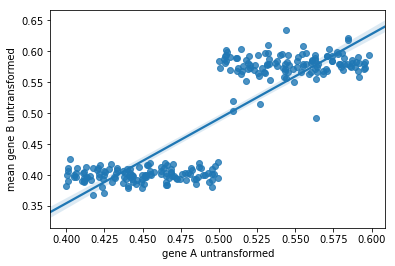

In [8]:
# Plot
sns.regplot(x='gene A untransformed',
            y='mean gene B untransformed',
           data = A_and_B_before_df)

## 2.  Trend of gene B with respect to A (decoder)

How is B changing with respect to A after applying our latent space transformation?

Here we are only changing samples **after** they have been encoded into the latent space and we apply our latent space transformation.  Therefore, any trends that we observe we conclude that this relationship is what the decoder is learning.

In [9]:
# Define function to apply latent space transformation and output reconstructed data

def interpolate_in_vae_latent_space_AB(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Sort target gene data by expression (lowest --> highest)
    target_gene_sorted = target_gene_data.sort_values()

    lowest_file = os.path.join(encoded_dir, "lowest_encoded_vae.txt")
    low_exp_encoded = pd.read_table(lowest_file, header=0, index_col=0)
    
    # Average gene expression across samples in each extreme group
    lowest_mean_encoded = low_exp_encoded.mean(axis=0)

    # Format and rename as "baseline"
    baseline_encoded = pd.DataFrame(
        lowest_mean_encoded, index=offset_encoded.columns).T
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        intermediate_target_gene_exp = target_gene_sorted[sample_id]
        print('gene A exp is {}'.format(intermediate_target_gene_exp))
        alpha = get_scale_factor(
            target_gene_sorted, intermediate_target_gene_exp, percent_low, percent_high)
        print('scale factor is {}'.format(alpha))
        predict = baseline_encoded + alpha * offset_encoded

        predict_encoded_df = pd.DataFrame(predict)
        predicted_encoded_sample_data = predicted_encoded_sample_data.append(predict_encoded_df, ignore_index=True)
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        predicted_sample_data = predicted_sample_data.append(predict_df, ignore_index=True)

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')
    
def get_scale_factor(target_gene_sorted, expression_profile,
                     percent_low, percent_high):
    """
    get_scale_factor(target_gene_sorted: dataframe,
                    expression_profile: dataframe,
                    percent_low: integer,
                    percent_high: integer,):

    input:
        target_gene_sorted: dataframe of sorted target gene expression

        expression_profile: dataframe of gene expression for selected sample

        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1

    computation:
        Determine how much to scale offset based on distance along the target gene expression gradient

    Output:
     scale factor = intermediate gene expression/ (average high target gene expression - avgerage low target gene expression) 
    """

    # Collect the extreme gene expressions
    # Get sample IDs with the lowest 5% of reference gene expression
    threshold_low = np.percentile(target_gene_sorted, percent_low)
    lowest = target_gene_sorted[target_gene_sorted <= threshold_low]

    # Get sample IDs with the highest 5% of reference gene expression
    threshold_high = np.percentile(target_gene_sorted, percent_high)
    highest = target_gene_sorted[target_gene_sorted >= threshold_high]

    # Average gene expression across samples in each extreme group
    lowest_mean = (lowest.values).mean()
    highest_mean = (highest.values).mean()

    # Different in extremes
    denom = highest_mean - lowest_mean

    # scale_factor is the proportion along the gene expression gradient
    scale_factor = expression_profile / denom

    return scale_factor

In [10]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_AB(sim_data,
                                   test_samples_sorted,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


gene A exp is 0.40005
scale factor is 0.4253390017674791
gene A exp is 0.40023000000000003
scale factor is 0.4255303803959459
gene A exp is 0.40085
scale factor is 0.4261895734495537
gene A exp is 0.4012
scale factor is 0.42656169856046144
gene A exp is 0.40137
scale factor is 0.4267424450429023
gene A exp is 0.40225
scale factor is 0.42767807389318446
gene A exp is 0.40501
scale factor is 0.43061254619634215
gene A exp is 0.40526
scale factor is 0.4308783498469905
gene A exp is 0.40628000000000003
scale factor is 0.43196282874163583
gene A exp is 0.40631999999999996
scale factor is 0.43200535732573947
gene A exp is 0.40684000000000003
scale factor is 0.43255822891908813
gene A exp is 0.41038
scale factor is 0.4363220086122686
gene A exp is 0.41115
scale factor is 0.43714068385626553
gene A exp is 0.41128000000000003
scale factor is 0.43727890175460266
gene A exp is 0.41145
scale factor is 0.4374596482370435
gene A exp is 0.41161000000000003
scale factor is 0.4376297625734585
gene A ex

scale factor is 0.5529779148088135
gene A exp is 0.52027
scale factor is 0.5531586612912545
gene A exp is 0.52268
scale factor is 0.5557210084835045
gene A exp is 0.52364
scale factor is 0.5567416945019941
gene A exp is 0.52546
scale factor is 0.5586767450787141
gene A exp is 0.5257
scale factor is 0.5589319165833364
gene A exp is 0.5263399999999999
scale factor is 0.5596123739289961
gene A exp is 0.52683
scale factor is 0.5601333490842669
gene A exp is 0.5282100000000001
scale factor is 0.5616005852358459
gene A exp is 0.52941
scale factor is 0.5628764427589579
gene A exp is 0.52987
scale factor is 0.5633655214761507
gene A exp is 0.53042
scale factor is 0.5639502895075772
gene A exp is 0.53133
scale factor is 0.5649178147959371
gene A exp is 0.53166
scale factor is 0.565268675614793
gene A exp is 0.5321199999999999
scale factor is 0.5657577543319858
gene A exp is 0.5324
scale factor is 0.566055454420712
gene A exp is 0.53268
scale factor is 0.5663531545094382
gene A exp is 0.53311999

**Plot**
Plot transformed gene expression A vs mean transformed expression of genes in set B

Q: What is the relationship between genes in set A and B?  As the expression of A varies how does the expression of B vary?

In [11]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(250, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM597217.CEL,0.588698,0.658995,0.507168,0.597505,0.446048,0.440019,0.414234,0.522333,0.511903,0.298343,...,0.435323,0.523467,0.567050,0.574536,0.588685,0.335117,0.511520,0.534952,0.604285,0.573375
Van_Delden_Kohler_0311_PT5_3.CEL,0.588699,0.659056,0.507209,0.597502,0.446041,0.440012,0.414223,0.522334,0.511901,0.298365,...,0.435316,0.523470,0.567053,0.574539,0.588680,0.335120,0.511522,0.534947,0.604283,0.573373
GSM567695.CEL,0.588704,0.659266,0.507353,0.597494,0.446017,0.439988,0.414184,0.522337,0.511896,0.298440,...,0.435294,0.523480,0.567065,0.574549,0.588663,0.335129,0.511529,0.534930,0.604278,0.573366
GSM617289.CEL,0.588707,0.659384,0.507435,0.597489,0.446003,0.439975,0.414162,0.522338,0.511893,0.298482,...,0.435281,0.523485,0.567072,0.574554,0.588654,0.335134,0.511532,0.534921,0.604275,0.573362
GSM546274.CEL,0.588708,0.659442,0.507474,0.597487,0.445996,0.439968,0.414152,0.522339,0.511892,0.298502,...,0.435275,0.523488,0.567076,0.574557,0.588649,0.335136,0.511534,0.534916,0.604273,0.573360


In [12]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

GSM597217.CEL                       0.462557
Van_Delden_Kohler_0311_PT5_3.CEL    0.462594
GSM567695.CEL                       0.462722
GSM617289.CEL                       0.462794
GSM546274.CEL                       0.462829
dtype: float64

In [13]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

A_and_B_predict_df = pd.merge(predict_A_exp.to_frame('gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A transformed,mean gene B transformed
GSM597217.CEL,0.388872,0.462557
Van_Delden_Kohler_0311_PT5_3.CEL,0.389093,0.462594
GSM567695.CEL,0.389855,0.462722
GSM617289.CEL,0.390286,0.462794
GSM546274.CEL,0.390495,0.462829


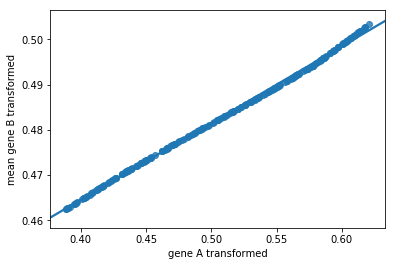

In [14]:
# Plot
sns.regplot(x='gene A transformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)

## 3.  Trend of gene B with respect to A (encoder)

How is B changing with respect to A after shifting input expression and then applying our latent space transformation?

Here we are only changing samples **before** they have been encoded into the latent space and then we apply our latent space transformation.  If we compare these trends with those from #2 module, which show what the decoder is supposedly learning, then we can conclude what the encoder is learning.

In [15]:
# Artificially shift gene A expression

# Get single sample
test_sample = test_samples_sorted.index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = test_samples_sorted.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
new_A_exp = np.linspace(0.41, 0.60, num=100)

for i in new_A_exp:
    test_samples_sorted.loc[test_sample,geneSetA_ls] = i
    A_exp_sample = test_samples_sorted.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM597217.CEL


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.3546,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.2944,0.53128,0.62551
1,0.3546,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.2944,0.53128,0.62551
2,0.3546,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.2944,0.53128,0.62551
3,0.3546,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.2944,0.53128,0.62551
4,0.3546,0.48779,0.46557,0.40792,0.37706,0.13863,0.099159,0.26799,0.24812,0.23688,...,0.45332,0.65551,0.60552,0.49703,0.55529,0.40825,0.60875,0.2944,0.53128,0.62551


In [16]:
# Define function to apply latent space transformation to SHIFTED data and output reconstructed data

def interpolate_in_vae_latent_space_shiftA(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "shifted_predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "shifted_predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        sample_exp = sample_data.loc[sample_id].to_frame().T
        
        # Use trained model to encode expression data into SAME latent space
        predict = loaded_model.predict_on_batch(sample_exp)

        predict_encoded_df = pd.DataFrame(predict)
        predicted_encoded_sample_data = predicted_encoded_sample_data.append(predict_encoded_df, ignore_index=True)
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict_encoded_df)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        predicted_sample_data = predicted_sample_data.append(predict_df, ignore_index=True)

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')

In [17]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_shiftA(sim_data,
                                   A_exp_sample_modified_df,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "shifted_predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(100, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.346119,0.472253,0.465425,0.402164,0.364047,0.115502,0.081423,0.261506,0.221483,0.211792,...,0.463589,0.685455,0.621450,0.498169,0.576065,0.403759,0.635327,0.284880,0.542535,0.644988
1,0.346102,0.472197,0.465101,0.402099,0.364088,0.115433,0.081441,0.261429,0.221420,0.211674,...,0.463588,0.685518,0.621498,0.498131,0.576091,0.403853,0.635268,0.284859,0.542539,0.645096
2,0.346086,0.472143,0.464778,0.402034,0.364128,0.115362,0.081459,0.261353,0.221358,0.211557,...,0.463588,0.685582,0.621548,0.498093,0.576119,0.403948,0.635207,0.284837,0.542545,0.645204
3,0.346086,0.472122,0.464459,0.401983,0.364171,0.115298,0.081479,0.261285,0.221303,0.211440,...,0.463586,0.685648,0.621609,0.498068,0.576154,0.404035,0.635145,0.284832,0.542566,0.645314
4,0.346102,0.472090,0.464165,0.401941,0.364219,0.115247,0.081500,0.261235,0.221261,0.211330,...,0.463591,0.685699,0.621664,0.498048,0.576189,0.404108,0.635083,0.284839,0.542592,0.645431


In [19]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

0    0.373674
1    0.373589
2    0.373503
3    0.373422
4    0.373348
dtype: float64

**Plot:** Original A vs Transformed A

In [20]:
# Join original expression of A and transformed expression of A
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_A_exp = predict_gene_exp[rep_gene_A]

original_A_vs_transformed_A_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_A_exp.to_frame('gene A transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_A_df.head()

,gene A untransformed,gene A transformed
0,0.410000,0.381094
1,0.411919,0.381511
2,0.413838,0.381930
3,0.415758,0.382344
4,0.417677,0.382774


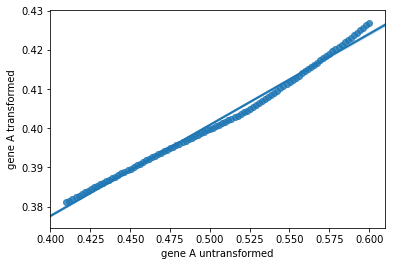

In [21]:
# Plot
sns.regplot(x='gene A untransformed',
            y='gene A transformed',
           data = original_A_vs_transformed_A_df)

**Plot:** Original A vs Mean(Transformed B)

In [22]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

original_A_vs_transformed_B_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_B_df.head()

,gene A untransformed,mean gene B transformed
0,0.410000,0.373674
1,0.411919,0.373589
2,0.413838,0.373503
3,0.415758,0.373422
4,0.417677,0.373348


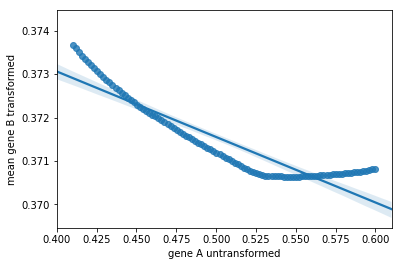

In [23]:
# Plot
# A before transformation vs B after transformation
sns.regplot(x='gene A untransformed',
            y='mean gene B transformed',
           data = original_A_vs_transformed_B_df)

**Plot:** Transformed A vs Mean(Transformed B)

In [24]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

A_and_B_predict_df = pd.merge(predict_A_exp.to_frame('gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A transformed,mean gene B transformed
0,0.381094,0.373674
1,0.381511,0.373589
2,0.381930,0.373503
3,0.382344,0.373422
4,0.382774,0.373348


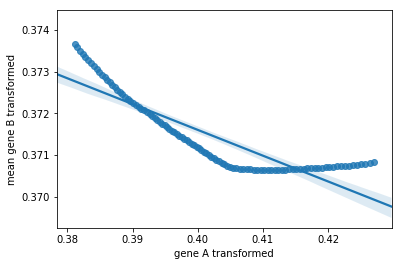

In [25]:
# Plot
sns.regplot(x='gene A transformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)